In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import seaborn as sns

In [5]:
# Параметры отображения графиков:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})
plt.style.use('seaborn-colorblind')

### Считывание и проверка данных

In [6]:
# Характеристики товаров:
data = pd.read_excel('dresses_dataset.xlsx')

In [7]:
data.head()

,Dress_ID,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Waistline,Material,FabricType,Decoration,Pattern Type,Recommendation
0,1006032852,Sexy,Low,4.6,M,Summer,o-neck,sleevless,empire,NaN,chiffon,ruffles,animal,1
1,1212192089,Casual,Low,0.0,L,Summer,o-neck,Petal,natural,microfiber,NaN,ruffles,animal,0
2,1190380701,vintage,High,0.0,L,Automn,o-neck,full,natural,polyster,NaN,NaN,print,0
3,966005983,Brief,Average,4.6,L,Spring,o-neck,full,natural,silk,chiffon,embroidary,print,1
4,876339541,cute,Low,4.5,M,Summer,o-neck,butterfly,natural,chiffonfabric,chiffon,bow,dot,0


In [8]:
# Количество строк и столбцов:
data.shape

(500, 14)

In [9]:
# Типы данных:
data.dtypes

Dress_ID            int64
Style              object
Price              object
Rating            float64
Size               object
Season             object
NeckLine           object
SleeveLength       object
Waistline          object
Material           object
FabricType         object
Decoration         object
Pattern Type       object
Recommendation      int64
dtype: object

In [10]:
# Пропуски по параметрам:
data.isna().sum()

Dress_ID            0
Style               0
Price               2
Rating              0
Size                0
Season              2
NeckLine            3
SleeveLength        2
Waistline          87
Material          128
FabricType        266
Decoration        236
Pattern Type      109
Recommendation      0
dtype: int64

In [11]:
# Количество уникальных значений в каждом столбце:
for col in data.columns:
    print(f'{col} - {len(data[col].unique())}')

Dress_ID - 475
Style - 13
Price - 8
Rating - 17
Size - 7
Season - 9
NeckLine - 17
SleeveLength - 18
Waistline - 5
Material - 24
FabricType - 23
Decoration - 25
Pattern Type - 15
Recommendation - 2


In [12]:
# Опечатки в значениях столбца Season:
data['Season'].unique()

array(['Summer', 'Automn', 'Spring', 'Winter', 'spring', 'winter', nan,
       'summer', 'Autumn'], dtype=object)

In [13]:
# Приводим наименования сезонов к единому формату:
data.loc[data['Season'] == 'summer', 'Season'] = 'Summer'
data.loc[data['Season'] == 'Automn', 'Season'] = 'Autumn'
data.loc[data['Season'] == 'spring', 'Season'] = 'Spring'
data.loc[data['Season'] == 'winter', 'Season'] = 'Winter'

In [14]:
# Опечатки в значениях столбца Size:
data['Size'].unique()

array(['M', 'L', 'XL', 'free', 'S', 'small', 's'], dtype=object)

In [15]:
# Приводим наименования размеров к единому формату:
data.loc[data['Size'] == 's', 'Size'] = 'S'
data.loc[data['Size'] == 'small', 'Size'] = 'S'

In [16]:
# Опечатки в значениях столбца Price:
data['Price'].unique()

array(['Low', 'High', 'Average', 'Medium', 'very-high', 'low', 'high',
       nan], dtype=object)

In [17]:
# Приводим наименования ценовых диапазонов к единому формату:
data.loc[data['Price'] == 'low', 'Price'] = 'Low'
data.loc[data['Price'] == 'high', 'Price'] = 'High'

In [18]:
# Опечатки в значениях столбца NeckLine:
data['NeckLine'].unique()

array(['o-neck', 'v-neck', 'boat-neck', 'peterpan-collor', 'ruffled',
       'turndowncollor', 'slash-neck', 'mandarin-collor', 'open',
       'sqare-collor', 'Sweetheart', 'sweetheart', nan, 'Scoop', 'halter',
       'backless', 'bowneck'], dtype=object)

In [19]:
# Приводим наименования к единому формату:
data.loc[data['NeckLine'] == 'sweetheart', 'NeckLine'] = 'Sweetheart'

In [20]:
# Опечатки в значениях столбца SleeveLength:
data['SleeveLength'].unique()

array(['sleevless', 'Petal', 'full', 'butterfly', 'short', 'threequarter',
       'halfsleeve', 'cap-sleeves', 'turndowncollor', 'threequater',
       'capsleeves', 'sleeveless', 'sleeevless', 'half', 'urndowncollor',
       'thressqatar', nan, 'sleveless'], dtype=object)

In [21]:
# Приводим наименования к единому формату:
data.loc[data['SleeveLength'] == 'sleevless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'sleeevless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'sleveless', 'SleeveLength'] = 'sleeveless'
data.loc[data['SleeveLength'] == 'threequater', 'SleeveLength'] = 'threequarter'
data.loc[data['SleeveLength'] == 'thressqatar', 'SleeveLength'] = 'threequarter'
data.loc[data['SleeveLength'] == 'half', 'SleeveLength'] = 'halfsleeve'
data.loc[data['SleeveLength'] == 'capsleeves', 'SleeveLength'] = 'cap-sleeves'
# Эта характеристика относится к описанию параметра NeckLine:
data.loc[(data['SleeveLength'] == 'urndowncollor') & (data['NeckLine'].isna()), 'NeckLine'] = 'turndowncollor'
data.loc[data['SleeveLength'] == 'urndowncollor', 'SleeveLength'] = np.nan

In [22]:
# Вариации наименований материалов:
data['Material'].unique()

array([nan, 'microfiber', 'polyster', 'silk', 'chiffonfabric', 'cotton',
       'nylon', 'other', 'milksilk', 'linen', 'rayon', 'lycra', 'mix',
       'acrylic', 'spandex', 'lace', 'modal', 'cashmere', 'viscos',
       'knitting', 'sill', 'wool', 'model', 'shiffon'], dtype=object)

In [23]:
# Приводим наименования к единому формату:
data.loc[data['Material'] == 'sill', 'Material'] = 'silk'
data.loc[data['Material'] == 'chiffonfabric', 'Material'] = 'shiffon'

In [24]:
# Опечатки наименований типов материалов:
data['FabricType'].unique()

array(['chiffon', nan, 'broadcloth', 'jersey', 'other', 'batik', 'satin',
       'flannael', 'worsted', 'woolen', 'poplin', 'dobby', 'knitting',
       'flannel', 'tulle', 'sattin', 'organza', 'lace', 'Corduroy',
       'wollen', 'knitted', 'shiffon', 'terry'], dtype=object)

In [25]:
# Приводим наименования к единому формату:
data.loc[data['FabricType'] == 'flannael', 'FabricType'] = 'flannel'
data.loc[data['FabricType'] == 'chiffon', 'FabricType'] = 'shiffon'

In [26]:
# Опечатки наименований рисунков:
data['Pattern Type'].unique()

array(['animal', 'print', 'dot', 'solid', nan, 'patchwork', 'striped',
       'geometric', 'plaid', 'leopard', 'floral', 'character', 'splice',
       'leapord', 'none'], dtype=object)

In [27]:
# Приводим наименования к единому формату:
data.loc[data['Pattern Type'] == 'leapord', 'Pattern Type'] = 'leopard'

Количество уникальных значений в столбце Dress_ID меньше количества строк в датафрейме, т.е. некоторые товарные позиции в таблице повторяются.

In [28]:
# Находим строки с дублирующимися кодами товаров:
data[data['Dress_ID'].duplicated(keep=False)].sort_values(by='Dress_ID').head(20)

,Dress_ID,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Waistline,Material,FabricType,Decoration,Pattern Type,Recommendation
454,549159213,Casual,Average,4.4,free,Summer,o-neck,cap-sleeves,natural,cotton,NaN,NaN,solid,0
180,549159213,Casual,Average,4.5,free,Summer,o-neck,short,natural,cotton,NaN,NaN,solid,1
429,560474456,Sexy,Low,4.4,free,Autumn,v-neck,sleeveless,natural,cotton,worsted,lace,solid,0
184,560474456,Sexy,Low,4.3,free,Winter,v-neck,sleeveless,natural,silk,worsted,lace,solid,1
250,699738864,Casual,Low,4.7,S,Summer,o-neck,full,natural,cotton,NaN,NaN,patchwork,0
336,699738864,Casual,Low,4.7,S,Summer,o-neck,full,natural,cotton,NaN,NaN,patchwork,0
361,709353440,cute,Average,4.7,M,Summer,o-neck,sleeveless,natural,shiffon,NaN,sashes,splice,0
133,709353440,cute,Average,4.7,L,Winter,o-neck,sleeveless,natural,shiffon,NaN,lace,solid,0
178,722565148,Sexy,Low,4.4,free,Autumn,o-neck,full,empire,cotton,NaN,NaN,leopard,0
496,722565148,Sexy,Low,4.3,free,Summer,o-neck,full,empire,cotton,NaN,NaN,NaN,0


В строках с дублирующимися кодами имеются незначительные различия в отдельных параметрах (например, одна и та же модель может быть отнесена к весеннему и летнему сезону, отличаться описанием отделки или размера). Для целей кластеризации будем считать, что выявленные повторы не оказывают существенного влияния на решаемую задачу.

In [29]:
# Считываем данные о продажах:
sales_data = pd.read_excel('dresses_sales.xlsx')

In [30]:
sales_data.head()

,Dress_ID,29/8/2013,31/8/2013,2013-02-09 00:00:00,2013-04-09 00:00:00,2013-06-09 00:00:00,2013-08-09 00:00:00,2013-10-09 00:00:00,2013-12-09 00:00:00,14/9/2013,...,24/9/2013,26/9/2013,28/9/2013,30/9/2013,2013-02-10 00:00:00,2013-04-10 00:00:00,2013-06-10 00:00:00,2010-08-10 00:00:00,2013-10-10 00:00:00,2013-12-10 00:00:00
0,1006032852,2114,2274,2491,2660,2727,2887,2930,3119,3204,...,3554,3624.0,3706,3746.0,3795.0,3832.0,3897,3923.0,3985.0,4048
1,1212192089,151,275,570,750,813,1066,1164,1558,1756,...,2710,2942.0,3258,3354.0,3475.0,3654.0,3911,4024.0,4125.0,4277
2,1190380701,6,7,7,7,8,8,9,10,10,...,11,11.0,11,11.0,11.0,11.0,11,11.0,11.0,11
3,966005983,1005,1128,1326,1455,1507,1621,1637,1723,1746,...,1878,1892.0,1914,1924.0,1929.0,1941.0,1952,1955.0,1959.0,1963
4,876339541,996,1175,1304,1396,1432,1559,1570,1638,1655,...,2032,2156.0,2252,2312.0,2387.0,2459.0,2544,2614.0,2693.0,2736


In [31]:
# Приводим все заголовки столбцов в формат DateTime:
for col in sales_data.columns[1:]:
    if isinstance(col, str):
        new_col = pd.to_datetime(col, format='%d/%m/%Y')
        sales_data = sales_data.rename(columns={col: new_col})

In [32]:
# Количество уникальных значений в столбце Dress_ID:
len(sales_data['Dress_ID'].unique())

475

В этой таблице также встречаются строки с дублирующимися кодами товаров, продажи по которым необходимо агрегировать для получения корректных данных.

In [33]:
# Добавляем вспомогательный столбец с уникальным кодом:
sales_data['ID'] = [i for i in range(len(sales_data))]

In [34]:
# Разворачиваем таблицу вертикально:
sales_data = pd.melt(sales_data, id_vars=['ID', 'Dress_ID'],
                     var_name='Date', value_name='Sales')

In [35]:
# Типы данных:
sales_data.dtypes

ID                   int64
Dress_ID             int64
Date        datetime64[ns]
Sales               object
dtype: object

In [36]:
# Преобразуем продажи в числовой формат:
sales_data['Sales'] = pd.to_numeric(sales_data['Sales'], errors='coerce')

In [37]:
# Находим строки с дублирующимися кодами товаров и датами:
sales_data[sales_data[['Dress_ID', 'Date']].duplicated(keep=False)].sort_values(by=['Dress_ID', 'Date']).head(20)

,ID,Dress_ID,Date,Sales
10180,180,549159213,2010-08-10,NaN
10454,454,549159213,2010-08-10,295.0
1180,180,549159213,2013-02-09,253.0
1454,454,549159213,2013-02-09,0.0
8680,180,549159213,2013-02-10,NaN
8954,454,549159213,2013-02-10,293.0
1680,180,549159213,2013-04-09,259.0
1954,454,549159213,2013-04-09,255.0
9180,180,549159213,2013-04-10,NaN
9454,454,549159213,2013-04-10,293.0


Строки с повторяющимися Dress_ID могут содержать одинаковые значения продаж напротив одинаковых дат либо разные (значение и NaN, значение и 0). Чтобы привести таблицу к уникальным значениям Dress_ID, сгруппируем данные по этому столбцу и выберем из значений столбца Sales максимальное.

In [38]:
sales_data = sales_data.groupby(['Dress_ID', 'Date'])['Sales'].max().reset_index()

In [39]:
sales_data.head(20)

,Dress_ID,Date,Sales
0,444282011,2010-08-10,98.0
1,444282011,2013-02-09,0.0
2,444282011,2013-02-10,91.0
3,444282011,2013-04-09,76.0
4,444282011,2013-04-10,96.0
5,444282011,2013-06-09,76.0
6,444282011,2013-06-10,96.0
7,444282011,2013-08-09,78.0
8,444282011,2013-08-29,0.0
9,444282011,2013-08-31,0.0


In [40]:
# Пропуски в данных о продажах:
sales_data.isna().sum()

Dress_ID       0
Date           0
Sales       1464
dtype: int64

In [41]:
# Создаем новый столбец и вносим в него порядковые номера месяцев:
sales_data['Season'] = sales_data['Date'].dt.month

In [42]:
# Словарь для преобразования номеров месяцев в названия сезонов:
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer',
           7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}

In [43]:
# Преобразуем порядковые номера месяцев в названия сезонов:
sales_data['Season'] = sales_data['Season'].apply(lambda x: seasons[x])

In [44]:
sales_data.head()

,Dress_ID,Date,Sales,Season
0,444282011,2010-08-10,98.0,Summer
1,444282011,2013-02-09,0.0,Winter
2,444282011,2013-02-10,91.0,Winter
3,444282011,2013-04-09,76.0,Spring
4,444282011,2013-04-10,96.0,Spring


In [45]:
# Вычисляем среднемесячные продажи по сезонам:
sales_data = sales_data.groupby(['Dress_ID', 'Season'])['Sales'].mean().reset_index()

In [46]:
sales_data.head()

,Dress_ID,Season,Sales
0,444282011,Autumn,85.181818
1,444282011,Spring,86.000000
2,444282011,Summer,58.000000
3,444282011,Winter,68.750000
4,510519284,Autumn,211.250000


In [47]:
# Разворачиваем таблицу горизонтально, чтобы среднемесячные продажи по сезонам были указаны напротив каждого кода товара:
sales_data = sales_data.pivot_table(index=['Dress_ID'], columns='Season', values='Sales').reset_index()

In [48]:
sales_data.head()

Season,Dress_ID,Autumn,Spring,Summer,Winter
0,444282011,85.181818,86.0,58.0,68.750000
1,510519284,211.250000,190.0,120.0,136.000000
2,511503677,615.181818,602.5,400.0,444.250000
3,520233308,663.625000,603.0,616.4,682.333333
4,522776523,585.125000,510.0,511.4,555.333333


In [49]:
# Пропуски в данных:
sales_data.isna().sum()

Season
Dress_ID    0
Autumn      0
Spring      0
Summer      0
Winter      0
dtype: int64

In [50]:
# Добавляем данные по среднемесячным продажам в общую таблицу с параметрами товаров:
data = pd.merge(data, sales_data, on='Dress_ID', how='outer')

In [51]:
data.head()

,Dress_ID,Style,Price,Rating,Size,Season,NeckLine,SleeveLength,Waistline,Material,FabricType,Decoration,Pattern Type,Recommendation,Autumn,Spring,Summer,Winter
0,1006032852,Sexy,Low,4.6,M,Summer,o-neck,sleeveless,empire,NaN,shiffon,ruffles,animal,1,3473.818182,3246.0,2970.333333,3363.25
1,1212192089,Casual,Low,0.0,L,Summer,o-neck,Petal,natural,microfiber,NaN,ruffles,animal,0,2521.090909,2202.0,1706.666667,2470.00
2,1190380701,vintage,High,0.0,L,Autumn,o-neck,full,natural,polyster,NaN,NaN,print,0,10.454545,9.0,8.500000,9.75
3,966005983,Brief,Average,4.6,L,Spring,o-neck,full,natural,silk,shiffon,embroidary,print,1,1835.090909,1698.0,1528.000000,1735.25
4,876339541,cute,Low,4.5,M,Summer,o-neck,butterfly,natural,shiffon,shiffon,bow,dot,0,1985.181818,1927.5,1720.000000,2016.25


### Корреляция продаж с другими параметрами

Text(0.5, 1, 'Матрица корреляции')

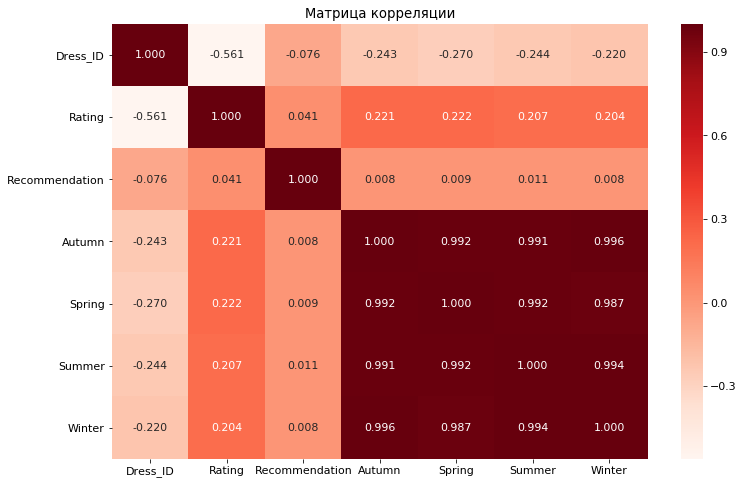

In [52]:
correlation = data.corr()
ax = sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds, fmt='0.3f')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.title('Матрица корреляции')

Среднемесячные продажи товаров в разные сезоны демонстрируют очень высокую корреляцию с показателями продаж тех же товаров в другие сезоны и низкую корреляцию с остальными числовыми параметрами таблицы. Корреляция продаж с рейтингом товара составляет порядка 0.2. Корреляция продаж с параметром, отражающим рекомендации, практически отсутствует (близка к нулю).

### Распределение значений параметров

In [53]:
# Составляем списки числовых и категорийных параметров:
num_cols = [col for col in data.columns if np.issubdtype(data.dtypes[col], np.number)]
cat_cols = [col for col in data.columns if col not in num_cols]

Text(0.5, 0.98, 'Распределение числовых параметров')

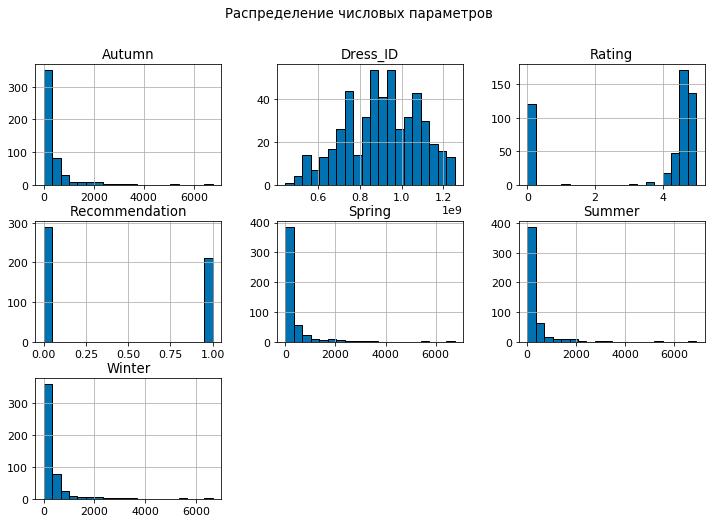

In [54]:
data[num_cols].hist(bins=20, edgecolor='black')
plt.suptitle('Распределение числовых параметров')

Выводы из анализа графиков:
- Продажи. Среднемесячные продажи товаров имеют экспоненциальное распределение, то есть гистограммы сильно смещены влево. Это означает, что основная масса товарных позиций демонстрирует низкие объемы продаж в любой сезон года. Высокие продажи наблюдаются у крайне малого числа товаров. Чем выше темпы продаж - тем меньше товаров им соответствуют, и эта зависимость может быть выражена экспоненциальной кривой падения.
- Значения столбца Recommendation демонстрируют на графике распределение Бернулли, в котором большая часть товарных позиций сконцентрированы в значении 0 и меньшая часть - в значении 1.
- Столбец Rating содержит большое количество возможных оценок, однако их распределение на гистограмме по своей форме приближается к распределению Бернулли. Наиболее значительная часть товаров имеют высокие оценки (> 4.4). Чуть меньшая, но сопоставимая по масштабу часть товаров, напротив, получили крайне низкие оценки, близкие к нулю. Средние оценки встречаются редко.

In [55]:
# Количество категорийных столбцов:
len(cat_cols)

11

In [56]:
# Количество строк и столбцов для размещения диаграмм в составе общей фигуры:
n_rows = 4
n_cols = 3

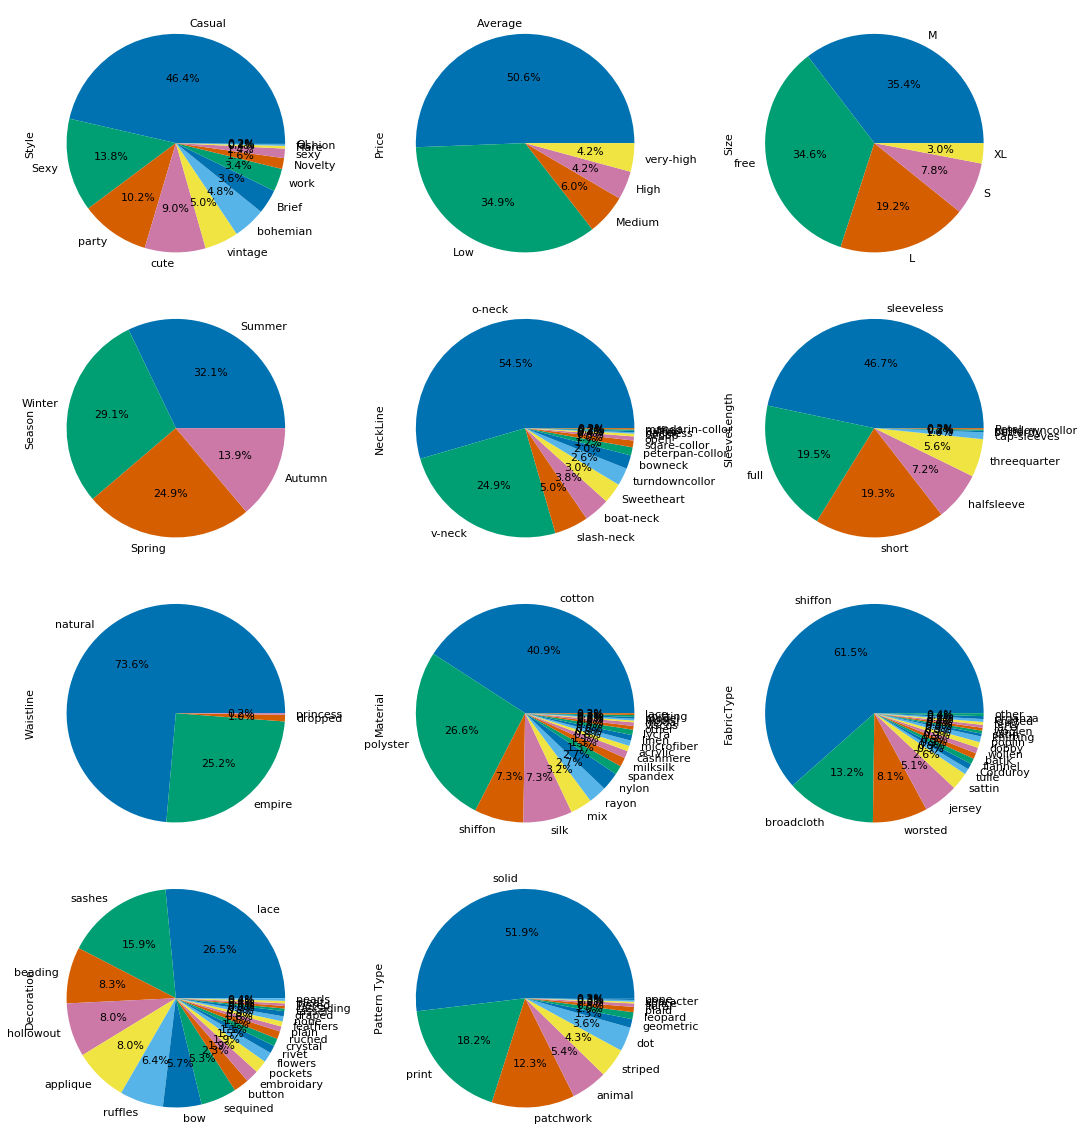

In [57]:
fig = plt.gcf()
fig.set_size_inches(n_cols * 5, n_rows * 4)
pos = 0  # Переменная определяет позицию следующего графика

for col in cat_cols:
    pos += 1
    sp = plt.subplot(n_rows, n_cols, pos)
    
    data[col].value_counts().plot.pie(autopct='%1.1f%%')

fig.tight_layout()

Категорийные параметры распределены неравномерно - по большинству параметров видно явное преобладание 2-3 наиболее распространенных групп:
- Наиболее широко в рассматриваемом ассортименте представлены платья повседневного стиля (46%).
- Преобладают платья средней (51%) и низкой (35%) ценовых категорий.
- Размерный ряд представлен преимущественно рамерами M, free и L (в общей сложности составляют около 90%).
- В разрезе сезонов наиболее широко представлены летние платья (32%), наименее широко - осенние (14%), однако в целом структура выглядит сбалансированной.
- Более половины всех позиций представляют платья с круглым вырезом, на круглый и V-образный вырез в совокупности приходится около 80% ассортимента.
- Представлены платья с длиной рукава всех возможных типов, однако почти половина ассортимента (около 47%) приходится на платья без рукавов.
- Почти три четверти ассортимента приходится на платья с естественной талией и еще примерно черверть - на платья с завышенной талией. Другие варианты посадки составляют ничтожно малую долю от общего числа.
- Среди материалов наиболее широко представлены хлопок (41%) и полиэстер (27%).
- В параметрах FabricType, Decoration, Material, Pattern Type и Waistline содержится большое количество пропусков (перечислены по мере убывания числа пропусков), что снижает их точность и значимость для кластеризации товаров.

In [58]:
# Сводная таблица:
data.describe()

,Dress_ID,Rating,Recommendation,Autumn,Spring,Summer,Winter
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,9.055417e+08,3.528600,0.420000,358.375839,313.776000,295.449800,335.410500
std,1.736190e+08,2.005364,0.494053,620.323352,605.761886,590.527734,611.572350
min,4.442820e+08,0.000000,0.000000,0.090909,0.500000,0.333333,0.000000
25%,7.673164e+08,3.700000,0.000000,54.650568,43.500000,38.500000,47.562500
50%,9.083296e+08,4.600000,0.000000,170.222222,125.000000,114.000000,142.791667
75%,1.039534e+09,4.800000,1.000000,390.885417,321.000000,310.100000,368.000000
max,1.253973e+09,5.000000,1.000000,6749.909091,6758.000000,6914.833333,6668.250000


Сводная таблица подтверждает особенности распределения числовых параметров, которые уже были отмечены при анализе графиков:
- Медианные значения темпов продаж для всех сезонов значительно ниже средних значений, т.е. в выборке есть небольшая доля объектов с высокими темпами продаж, в то время как для основной части ассортимента характерны более низкие продажи.
- Медианное значение столбца Rating приближается к верхней границе диапазона (при пятибалльной шкале медиана составляет 4.6).
- Столбец Recommendation содержит бинарные значения, поэтому медиана равна минимуму.

### Предобработка данных для моделей

In [59]:
# Инструменты для обработки данных:
scaler = StandardScaler()  # Стандартизация числовых столбцов
ohe = OneHotEncoder(sparse=False)  # Кодировка категорийных столбцов
imp = SimpleImputer(strategy='most_frequent')  # Заполнение пропусков категорийных столбцов

In [60]:
# Объединяем все виды обработки данных в один процесс:
preprocessor = make_column_transformer((scaler, num_cols),
                                       (make_pipeline(imp, ohe), cat_cols),
                                       remainder='drop')

In [61]:
# Убираем из списка числовых столбцов первое значение (Dress_ID):
num_cols = num_cols[1:]

In [62]:
# Обработанные данные:
X_processed = preprocessor.fit_transform(data)

In [63]:
# Проверяем количество строк и параметров:
X_processed.shape

(500, 140)

Полученное количество параметров явно превосходит оптимальное для использования в моделях кластеризации KMeans. Поэтому перед созданием моделей применяем Principal Component Analysis (PCA) для выбора наиболее значимых параметров и ускорения последующих расчетов.

In [64]:
# Диапазон для подбора оптимального количества ключевых компонентов:
components_range = range(2, 20)

In [65]:
# Список для добавления значений explained_variance_ratio_:
explained_variances = []

In [66]:
# Определяем показатель explained_variance_ratio_ для каждого значения диапазона:
for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_processed)
    explained_variance = pca.explained_variance_ratio_.mean()
    print(f'{n_components} компонентов - {explained_variance}')
    explained_variances.append(explained_variance)

2 компонентов - 0.2065076355264392
3 компонентов - 0.1632160369174319
4 компонентов - 0.13264525592149923
5 компонентов - 0.11336903659722655
6 компонентов - 0.1000140048443145
7 компонентов - 0.09002396845861478
8 компонентов - 0.0819562327276426
9 компонентов - 0.0755020370813308
10 компонентов - 0.07024879130872526
11 компонентов - 0.06575303999077792
12 компонентов - 0.061842355916433035
13 компонентов - 0.058501491360613125
14 компонентов - 0.05554680784926229
15 компонентов - 0.05291363052864996
16 компонентов - 0.05049069653842472
17 компонентов - 0.04828230228275634
18 компонентов - 0.04627118298609749
19 компонентов - 0.04443840891249946


Text(0.5, 1.0, 'Principal Component Analysis\n(Подбор оптимального числа параметров)')

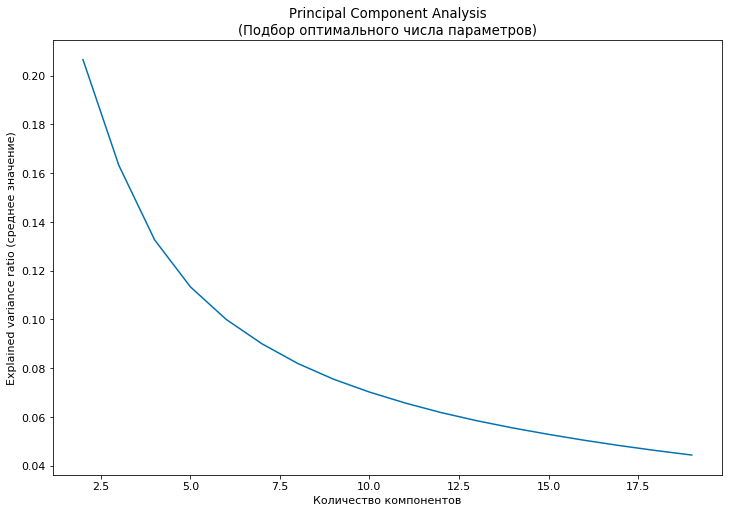

In [67]:
plt.plot(components_range, explained_variances)
plt.xlabel('Количество компонентов')
plt.ylabel('Explained variance ratio (среднее значение)')
plt.title('Principal Component Analysis\n(Подбор оптимального числа параметров)')

In [68]:
# Ограничиваем входные данные 10 наиболее значимыми параметрами:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_processed)

### KMeans Clustering
#### Определение оптимального количества кластеров через параметр inertia

In [69]:
# Список для добавления значений inertia (характеризует удаленность точек кластера от его центра):
distances = []

In [70]:
# Дипазон рассматриваемых значений:
clusters_range = range(2, 35)

In [71]:
# Подбираем оптимальное количество кластеров в модели через показатель inertia:
for n_clusters in clusters_range:    
    model = KMeans(n_clusters=n_clusters)
    model.fit(X_pca)
    distances.append(model.inertia_)

In [72]:
for n_clusters, distance in zip(clusters_range, distances):
    print(f'{n_clusters} кластеров - {distance}')

2 кластеров - 3484.0207569049526
3 кластеров - 2815.515415068492
4 кластеров - 2444.9912325801524
5 кластеров - 2084.268322512088
6 кластеров - 1961.3326492219394
7 кластеров - 1836.625824536541
8 кластеров - 1752.8530838410197
9 кластеров - 1643.4464556908556
10 кластеров - 1586.4496007835778
11 кластеров - 1529.5175997000572
12 кластеров - 1480.7317761993665
13 кластеров - 1430.8651156183987
14 кластеров - 1407.9582432047487
15 кластеров - 1358.410764883897
16 кластеров - 1331.6958466273609
17 кластеров - 1309.4868060656672
18 кластеров - 1283.6673547726696
19 кластеров - 1251.9080065570063
20 кластеров - 1233.0548198784618
21 кластеров - 1214.0601901243922
22 кластеров - 1198.902769843137
23 кластеров - 1167.9533822590645
24 кластеров - 1158.2110510577945
25 кластеров - 1138.9421004705252
26 кластеров - 1130.7704417978227
27 кластеров - 1099.3350825904222
28 кластеров - 1093.1570250147602
29 кластеров - 1070.7435415824355
30 кластеров - 1049.0569755915803
31 кластеров - 1043.5890614

Text(0.5, 1.0, 'Подбор оптимального количества кластеров')

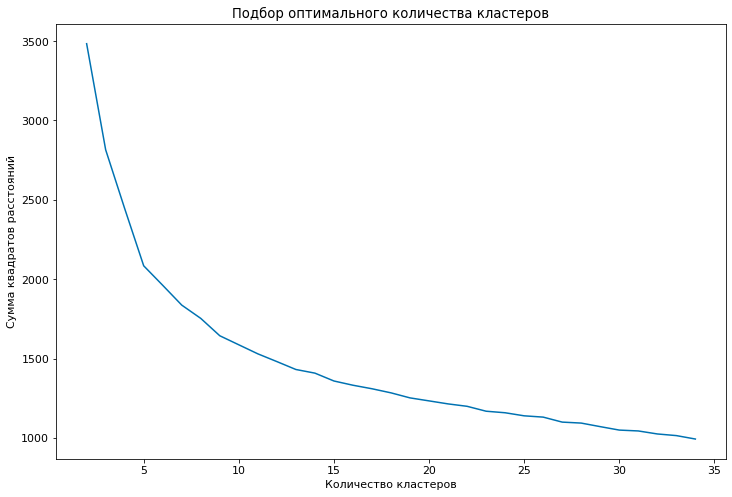

In [73]:
plt.plot(clusters_range, distances)
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Подбор оптимального количества кластеров')

In [74]:
# Создаем модель для определения 5 кластеров:
model = KMeans(n_clusters=5)

In [75]:
# Идентификация кластеров:
data['Cluster_KMeans'] = model.fit_predict(X_pca)

In [76]:
def clusters_piechart(seq):
    """Функция выводит график соотношения кластеров.
    Аргументы:
        seq - pandas.Series с кодами кластеров."""
    seq.value_counts().plot.pie(autopct='%1.1f%%')
    plt.title('Распределение товаров по кластерам')

In [77]:
def plot_clusters(df, cluster: str):
    """Функция выводит график распределения товаров,
    относящихся к разным кластерам, в осях,
    отображающих продажи и рейтинг.
    Аргументы:
        df - pandas.DataFrame.
        cluster - наименование столбца с кластерами."""
    plt.scatter(df['Summer'], df['Rating'], c=df[cluster])
    plt.xlabel('Средние продажи в летний сезон, ед./мес.')
    plt.ylabel('Рейтинг')
    plt.title(f'Кластеры')

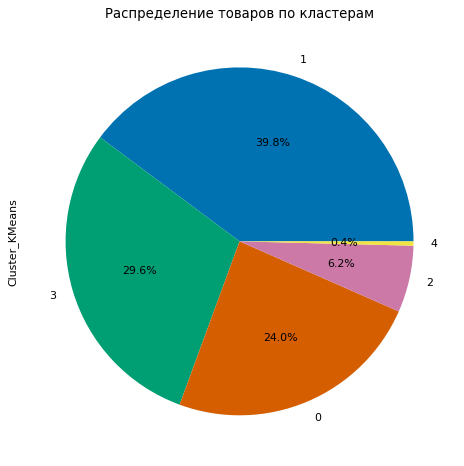

In [78]:
clusters_piechart(data['Cluster_KMeans'])

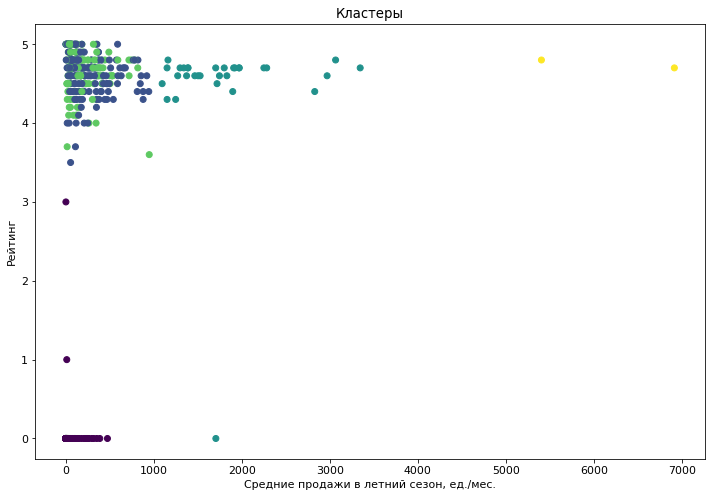

In [79]:
# Визуализация кластеров:
plot_clusters(data, 'Cluster_KMeans')

- Два кластера в левом верхнем углу графика почти полностью перекрывают друг друга, то есть товары двух разных групп демонстрируют сопоставимые темпы продаж и рейтинги. Это может быть результатом неправильно выбранного количества кластеров либо наличия других значимых параметров отличия между ними, не отраженных на двухмерном графике.
- На графике видно, что точки некоторых кластеров достаточно широко распределены вдоль оси y, то есть товары с разными рейтингами демонстрируют сопоставимые темпы продаж. Однако количество точек с нехарактерно высокими или низкими рейтингами в пределах каждого кластера ограничено, то есть это единичные "выбросы" или аномалии.
- Один из кластеров составляет менее 1% от общего числа товаров и значительно уступает по объему остальным кластерам, что ставит под сомнение его значимость в полученной структуре товаров. Это единичные товары с нехарактерно высокими темпами продаж и высокими рейтингами, расположенные на значительном удалении от основной массы точек на графике.

#### Определение оптимального количества кластеров через silhouette_score

In [80]:
# Дипазон рассматриваемых значений:
clusters_range = range(2, 10)

In [81]:
# Список для добавления значений silhouette_score:
coefs = []

In [82]:
# Перебираем возможные значения количества кластеров:
for n_clusters in clusters_range:
    # Для каждого количества делаем прогноз:
    model = KMeans(n_clusters=n_clusters)
    prediction = model.fit_predict(X_pca)
    # Вычисляем показатели точности:
    score = silhouette_score(X_pca, prediction)
    print(f'{n_clusters} кластеров - {score}')
    coefs.append(score)

2 кластеров - 0.5207702390663362
3 кластеров - 0.24972157673784287
4 кластеров - 0.22316012345753433
5 кластеров - 0.23060618961491586
6 кластеров - 0.2183801460939834
7 кластеров - 0.19037971514945454
8 кластеров - 0.1813758708764292
9 кластеров - 0.17142470674446997


Text(0.5, 1.0, 'Подбор оптимального количества кластеров')

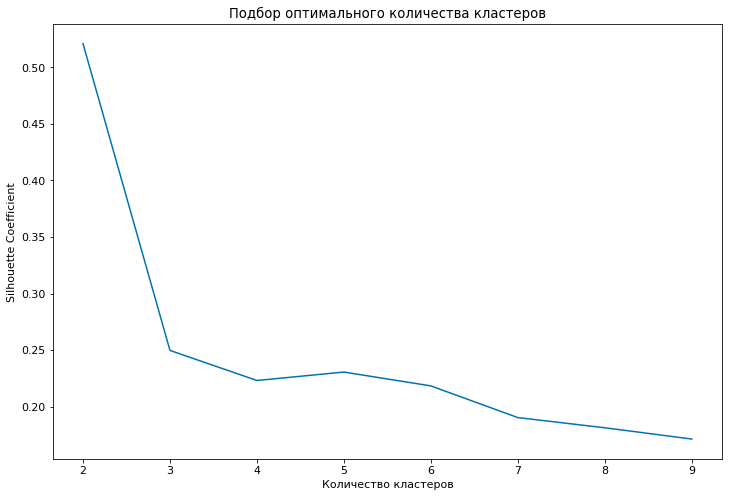

In [83]:
plt.plot(clusters_range, coefs)
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Coefficient')
plt.title('Подбор оптимального количества кластеров')

In [84]:
# Создаем модель для определения 4 кластеров:
model = KMeans(n_clusters=4)

In [85]:
# Идентификация кластеров:
data['Cluster_KMeans'] = model.fit_predict(X_pca)

In [86]:
# Соотношение кластеров:
data['Cluster_KMeans'].value_counts(normalize=True)

0    0.404
1    0.296
2    0.240
3    0.060
Name: Cluster_KMeans, dtype: float64

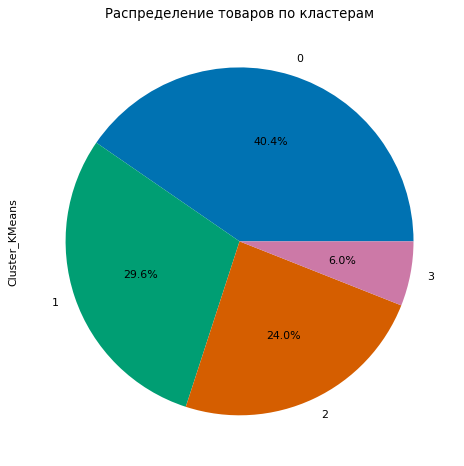

In [87]:
clusters_piechart(data['Cluster_KMeans'])

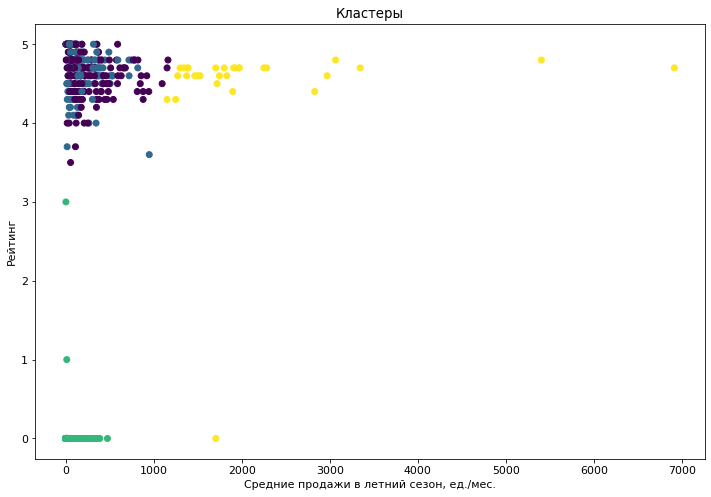

In [88]:
# Визуализация кластеров:
plot_clusters(data, 'Cluster_KMeans')

Модель выделила 4 группы товаров:
- Группа 1. Высокие рейтинги - преимущественно средние и высокие продажи;
- Группа 2. Низкие рейтинги - низкие продажи (самый маленький кластер);
- Группы 3 и 4. Преимущественно высокие рейтинги - преимущественно низкие продажи (кластеры перекрывают друг друга и являются наиболее крупными).

### BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

In [89]:
# Формируем модель для определения 4 кластеров:
model = Birch(branching_factor=50, threshold=0.5, n_clusters=4)

In [90]:
# Т.к. алгоритм хранит в памяти только значимые данные,
# передаем весь массив, без предварительной обработки через PCA:
data['Cluster_Birch'] = model.fit_predict(X_processed)

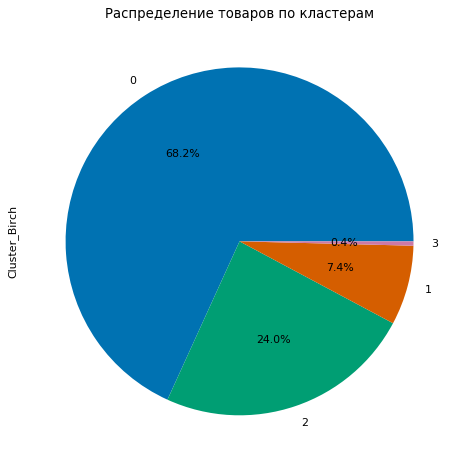

In [91]:
# Соотношение кластеров:
clusters_piechart(data['Cluster_Birch'])

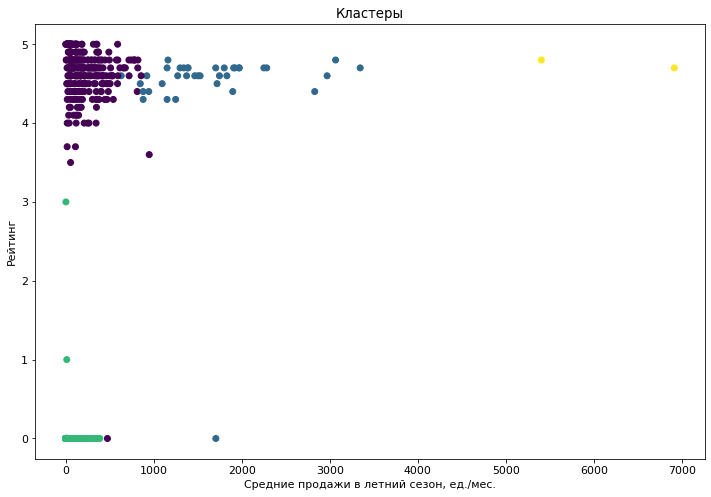

In [92]:
# Визуализация кластеров:
plot_clusters(data, 'Cluster_Birch')

Преимущество полученной структуры данных перед предыдущим вариантом в том, что кластеры на графике не перекрывают друг друга и имеют более четкие и логически обоснованные границы. Алгоритм разделил товары на 4 группы:
- Группа 1. Высокие рейтинги - низкие продажи (самый крупный кластер).
- Группа 2. Низкие рейтинги - низкие продажи (сравнительно небольшой кластер).
- Группа 3. Высокие рейтинги - средние продажи.
- Группа 4. Высокие рейтинги - высокие продажи (самый малочисленный кластер, по сути - единичные аномалии).

### Agglomerative hierarchical clustering

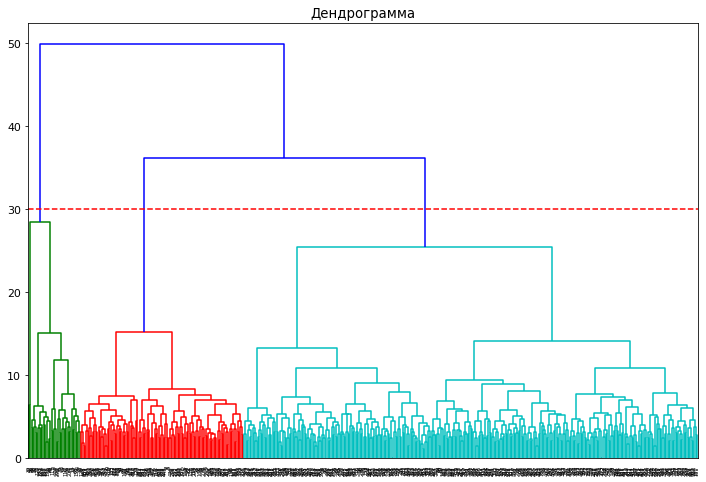

In [93]:
plt.title('Дендрограмма')
shc.dendrogram(shc.linkage(X_processed, method='ward'));
plt.axhline(y=30, color='r', linestyle='--')

In [94]:
# Формируем модель для 3 кластеров:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

In [95]:
# Идентификация кластеров:
data['Cluster_Aglom'] = model.fit_predict(X_processed)

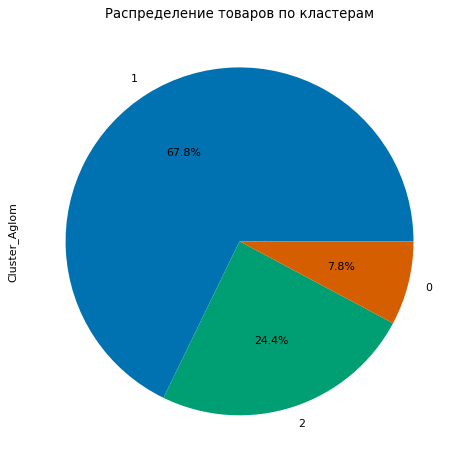

In [96]:
# Соотношение кластеров:
clusters_piechart(data['Cluster_Aglom'])

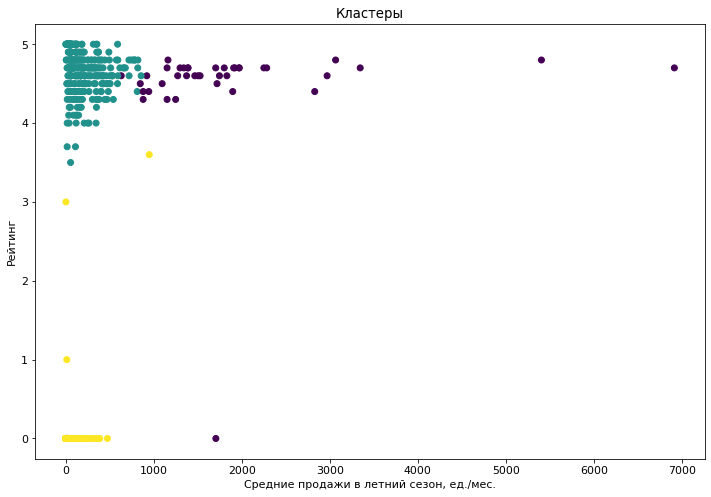

In [97]:
# Визуализация кластеров:
plot_clusters(data, 'Cluster_Aglom')

Полученная структура данных схожа с результатом модели BIRCH в том, что кластеры на графике не перекрывают друг друга и имеют более четкие и понятные границы. Отличием является то, что при формировании 3 кластеров самая маленькая группа товаров с нехарактерно высокими продажами была отнесена к соседней более крупной группе товаров с преимущественно средними продажами. Таким образом, все товары подразделаются на 3 группы:
- Группа 1. Низкие рейтинги - низкие продажи.
- Группа 2. Высокие рейтинги - низкие продажи (самый крупный кластер).
- Группа 3. Высокие рейтинги - преимущественно средние и высокие продажи.